In [1]:
from gwdetectors import *
from postprocessing import * 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import glob
from decimal import Decimal

In [90]:
frequencies=[0.4,0.8,1.2,1.6,2.0]

filepath = '/fs/lustre/cita/jewelcao/results/hp_true/hb/2.0_1e-2'

files = glob.glob(f'{filepath}/results*.pickle')
print(len(files))

dicts = []
for i in range(len(files)): 
    with open(f"{filepath}/results_{i}.pickle", "rb") as f:
        result = pickle.load(f)
        dicts.append(result)

merged_results = merge_dicts(dicts)

44


In [91]:
newpath = '/fs/lustre/cita/jewelcao/plots/hp_true/hb/2.0_1e-2' 

In [92]:
if os.path.exists(newpath):
    response = input(f"Path '{newpath}' already exists. Overwrite files? (y/N): ")
    if response.lower() not in ['y', 'yes']:
        print("Operation cancelled.")
        pass
    else:
        os.mkdir(newpath)
else: 
    os.mkdir(newpath)

In [93]:
merged_results.keys()

dict_keys(['true pole', 'true azim', 'true psi', 'match', 'filters', 'snrs', 'sky_coords', 'vars'])

In [94]:
with open(f"{filepath}/info.pickle", "rb") as f: 
    info = pickle.load(f)
    print(info)

{'true_mode': ['hp'], 'strain_mode': ['hb'], 'a': 1873.7028625066605, 'A': 1e-23, 'c': 0.01, 'dt': 0, 'phi': 0, 'geocent': 0, 'coord': 'geographic', 'network': Network(
  TwoArmDetector( H_aligo-design, location = (-7.209704e-03, -1.279117e-02, 1.534512e-02) sec, arms = ( (-2.987302e-06, 1.067179e-05, 7.430539e-06) sec, (-1.219481e-05, 3.481614e-07, -5.402717e-06) sec, ) psd = OneSidedPowerSpectralDensity(aligo-design, freq within [5.000000e+00 5.000000e+03])), long-wavelength approximation = False, ),
  TwoArmDetector( L_aligo-design, location = (-2.477582e-04, -1.833363e-02, 1.075496e-02) sec, arms = ( (-1.273647e-05, -1.889051e-06, -3.498275e-06) sec, (3.972636e-06, -6.509975e-06, -1.094817e-05) sec, ) psd = OneSidedPowerSpectralDensity(aligo-design, freq within [5.000000e+00 5.000000e+03])), long-wavelength approximation = False, ),
  TwoArmDetector( V_advirgo-design, location = (1.516507e-02, 2.811911e-03, 1.460536e-02) sec, arms = ( (-7.009431e-06, 2.086338e-06, 6.830342e-06) sec

In [95]:
CE_filters = np.array([np.sum(merged_results['filters'][i][4:])**2 
                       for i in range(len(merged_results['filters']))])**0.5
CE_snrs = np.array([np.sum(merged_results['snrs'][i][4:])**2 
                    for i in range(len(merged_results['snrs']))])**0.5
others_filters = np.array([np.sum(np.array(merged_results['filters'][i][:4])**2) 
                           for i in range(len(merged_results['filters']))])**0.5
others_snrs = np.array([np.sum(np.array(merged_results['snrs'][i][:4])**2) 
                        for i in range(len(merged_results['snrs']))])**0.5

In [96]:
CE_match = np.abs(CE_filters/CE_snrs)
others_match = np.abs(others_filters / others_snrs)

In [97]:
summary_statistics = {}
CE_stats = {'average CE match': np.mean(CE_match), 'median CE match':np.median(CE_match)} 
excluding_CE_stats = {'average match excluding CE': np.mean(others_match), 
                      'median match excluding CE':np.median(others_match)}

In [98]:
others_thresholds = {}
CE_thresholds={}
for B in [2, 10, 50, 100]:
    others_threshold = approx_threshold(np.full(np.shape(others_match), B), others_match)
    CE_threshold = approx_threshold(np.full(np.shape(CE_match), B), CE_match)
    minimum_threshold = np.min(others_threshold)
    average_threshold = np.mean(others_threshold)
    median_threshold = np.median(others_threshold)
    average_CE_threshold = np.mean(CE_threshold)
    median_CE_threshold = np.median(CE_threshold)
    minimum_CE_threshold = np.min(CE_threshold)
    others_thresholds[f'{B}'] =  {'average threshold':average_threshold, 
                                  'median threshold':median_threshold,
                                 'minimum threshold':minimum_threshold}
    CE_thresholds[f'{B}'] =  {'average threshold':average_CE_threshold, 
                              'median threshold':median_CE_threshold,
                             'minimum threshold':minimum_threshold}
standard_threshold = np.sqrt(1 / np.abs(others_match**2 - 1))
others_thresholds['standard'] = {'average threshold':np.mean(standard_threshold),
                                'median threshold':np.median(standard_threshold),
                                'minimum threshold':np.min(standard_threshold)}
standard_CE_threshold = np.sqrt(1 / np.abs(CE_match**2 - 1))
CE_thresholds['standard'] = {'average threshold':np.mean(standard_CE_threshold),
                                'median threshold':np.median(standard_CE_threshold),
                                'minimum threshold':np.min(standard_CE_threshold)}
excluding_CE_stats['thresholds'] = others_thresholds
CE_stats['thresholds'] = CE_thresholds

In [99]:
summary_statistics['CE'] = CE_stats
summary_statistics['excluding CE'] = excluding_CE_stats

In [100]:
summary_statistics

{'CE': {'average CE match': 0.9997930972329637,
  'median CE match': 0.9998857379082564,
  'thresholds': {'2': {'average threshold': 285.2334878760328,
    'median threshold': 77.97182980542325,
    'minimum threshold': 2.0630146176255835},
   '10': {'average threshold': 519.8710413847664,
    'median threshold': 142.11268340707053,
    'minimum threshold': 3.760082890839011},
   '50': {'average threshold': 677.623536143068,
    'median threshold': 185.23612856867481,
    'minimum threshold': 4.9010628826228775},
   '100': {'average threshold': 735.2086774113614,
    'median threshold': 200.97768425951307,
    'minimum threshold': 5.317560219871563},
   'standard': {'average threshold': 242.25501942530312,
    'median threshold': 66.2231748620931,
    'minimum threshold': 21.76635565106279}}},
 'excluding CE': {'average match excluding CE': 0.9497933305146335,
  'median match excluding CE': 0.9543643902724845,
  'thresholds': {'2': {'average threshold': 5.881016991772336,
    'median t

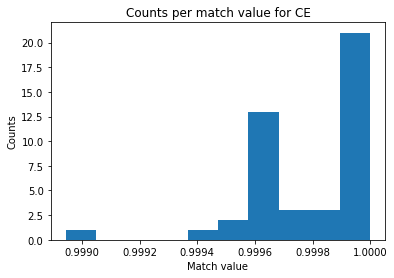

In [101]:
plt.title('Counts per match value for CE')
plt.xlabel('Match value')
plt.ylabel('Counts')
plt.hist(CE_match, bins=10)
plt.savefig(f'{newpath}/hist_CE')
plt.show()

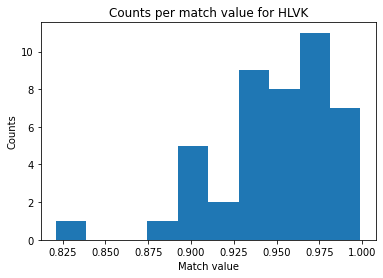

In [102]:
plt.title('Counts per match value for HLVK')
plt.xlabel('Match value')
plt.ylabel('Counts')
plt.hist(others_match, bins=10)
plt.savefig(f'{newpath}/hist_HLVK')
plt.show()

In [103]:
with open(f'{newpath}/summary_stats.pickle', 'wb') as fp:
    pickle.dump(summary_statistics, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [104]:
vars_= [item[0] for item in merged_results['vars']]
psis, t0s, phis = zip(*vars_)

In [105]:
sky_coords_ = [item[0] for item in merged_results['sky_coords']]
azims = merged_results['true azim']
poles = merged_results['true pole']
strain_azims, strain_poles = zip(*sky_coords_)

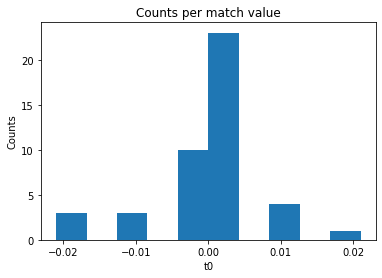

In [106]:
plt.title('Counts per match value')
plt.xlabel('t0')
plt.ylabel('Counts')
plt.hist(t0s, bins=10)
plt.savefig(f'{newpath}/t0_hist')
plt.show()

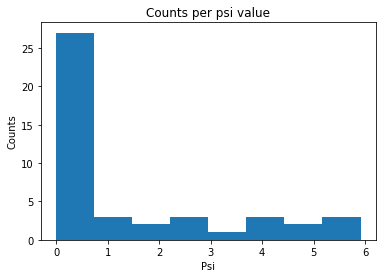

In [107]:
plt.title('Counts per psi value')
plt.xlabel('Psi')
plt.ylabel('Counts')
plt.hist(psis, bins=8)
plt.plot()
plt.savefig(f'{newpath}/psi_hist')
plt.show()

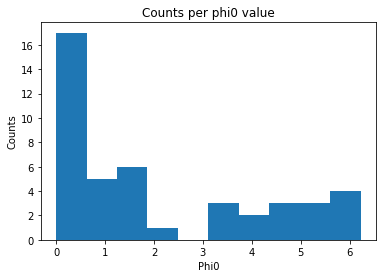

In [108]:
plt.title('Counts per phi0 value')
plt.xlabel('Phi0')
plt.ylabel('Counts')
plt.hist(phis, bins=10)
plt.savefig(f'{newpath}/phi0_hist')
plt.show()

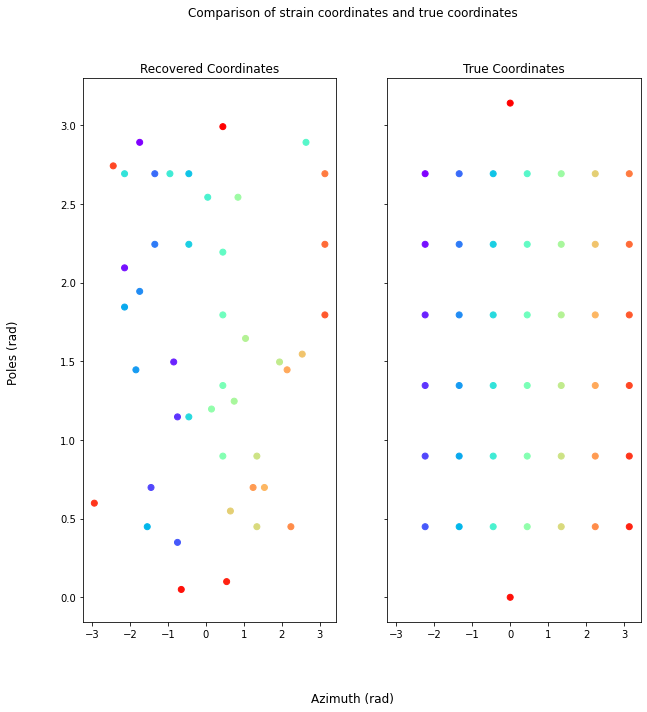

In [109]:
## NOTE: since I only got the first value in max_sky_coords, it sort of makes sense that everything is at 
# azim = -pi, since that's where the array starts
# Part of it might also be that the difference is so small np.where doesn't register it

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0,1,len(azims)))
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle('Comparison of strain coordinates and true coordinates')
fig.supxlabel('Azimuth (rad)')
fig.supylabel('Poles (rad)')
ax1.set_title('Recovered Coordinates')
ax1.scatter(strain_azims, strain_poles, c=colors)
ax2.set_title('True Coordinates')
ax2.scatter(azims, poles, c=colors)
plt.savefig(f'{newpath}/coordinate_comparison')
plt.show()

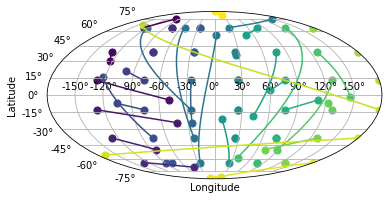

In [110]:
color_map = plt.cm.viridis(np.linspace(0, 1, len(azims)))

fig = plt.figure()
ax = fig.add_subplot(111, projection="mollweide")
for i in range(len(azims)):
    ax.scatter(strain_azims[i], np.array(strain_poles[i]) - np.pi/2, c=[color_map[i]], s=50, 
               vmin=0.8, vmax=1.0)
    ax.scatter(azims[i], np.array(poles[i]) - np.pi/2, c=[color_map[i]], s=50, 
               vmin=0.8, vmax=1.0)
    ax.plot([strain_azims[i], azims[i]], [np.array(strain_poles[i]) - np.pi/2, np.array(poles[i]) - np.pi/2],
            c=color_map[i])
ax.grid(True)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("Best match for true signal coordinates")
plt.savefig(f'{newpath}/coordinate_comparison_skymap')
plt.show()

# Server resolution

In [13]:
names_range = [2, 8, 16, '-f', 45, 64]

matches_range = {}
azim_pole = []
for i in range(2):
    matches = []
    for name in names_range: 
        with open(f"../results/server_resolution/results_{i}_{name}.pickle",'rb') as file: 
            result = pickle.load(file)
            matches.append(result['match'])
    matches_range[f'{i}'] = matches

In [14]:
names_num = [8, 16, 32, 45, 64, 72, 90, 128, 180]

matches_num = {}
for i in range(2):
    matches = []
    for name in names_num: 
        with open(f"../results/server_resolution/results_{i}_num{name}.pickle",'rb') as file: 
            result = pickle.load(file)
            matches.append(result['match'])
    matches_num[f'{i}'] = matches

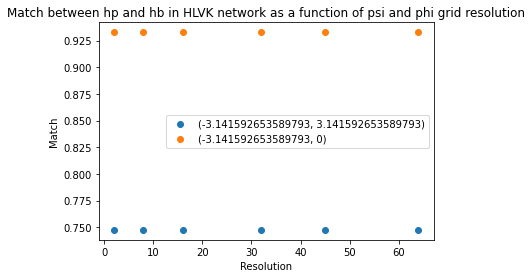

In [20]:
names_range = [2, 8, 16, 32, 45, 64]
true_coords = [(-np.pi, np.pi), (-np.pi, 0), (np.pi, np.pi), (np.pi, 0)]

plt.title('Match between hp and hb in HLVK network as a function of psi and phi grid resolution')
plt.xlabel('Resolution')
plt.ylabel('Match')
plt.scatter(names_range, matches_range[f'{0}'], label=f'{true_coords[0]}')
plt.scatter(names_range, matches_range[f'{1}'], label=f'{true_coords[1]}')
plt.legend()
plt.savefig('/fs/lustre/cita/jewelcao/plots/psi_phi_resolution')
plt.show()

info_range = {'a':'CE_fsr', 'c':1e-4, 'freq_res':120, 'strain_res':45, 
        'true_mode': 'hp', 'strain_mode':'hb', 'network':'HLVK'}

with open('/fs/lustre/cita/jewelcao/plots/psi_phi_resolution_meta.pickle', 'wb') as fp:
    pickle.dump(info_range, fp, protocol=pickle.HIGHEST_PROTOCOL)

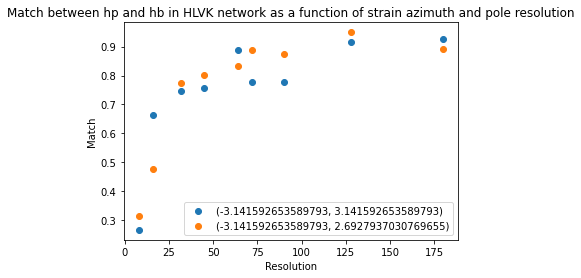

In [21]:
names_range = [8, 16, 32, 45, 64, 72, 90, 128, 180]
true_coords = [(-np.pi, np.pi), (-3.141592653589793, 2.6927937030769655), (np.pi, np.pi), (np.pi, 0)]

plt.title('Match between hp and hb in HLVK network as a function of strain azimuth and pole resolution')
plt.xlabel('Resolution')
plt.ylabel('Match')
plt.scatter(names_num, matches_num[f'{0}'], label=f'{true_coords[0]}')
plt.scatter(names_num, matches_num[f'{1}'], label=f'{true_coords[1]}')
plt.legend()
plt.savefig('/fs/lustre/cita/jewelcao/plots/strain_resolution')
plt.show()

info_num = {'a':'CE_fsr', 'c':1e-4, 'freq_res':120, 'psi_phi_res':16, 
        'true_mode': 'hp', 'strain_mode':'hb', 'network':'HLVK'}

with open('/fs/lustre/cita/jewelcao/plots/strain_resolution_meta.pickle', 'wb') as fp:
    pickle.dump(info_num, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
names_numpts = [80, 120, 160, 200, 240]

matches_numpts = {}
for i in range(2):
    matches = []
    for name in names_numpts: 
        with open(f"../results/server_resolution/results_{i}_numpts{name}.pickle",'rb') as file: 
            result = pickle.load(file)
            matches.append(result['match'])
    matches_numpts[f'{i}'] = matches

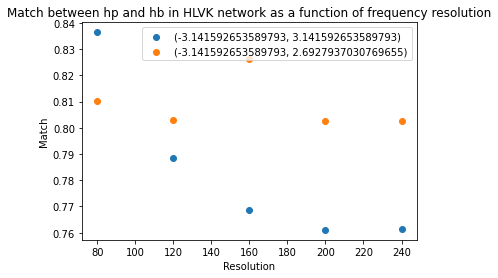

In [23]:
true_coords = [(-np.pi, np.pi), (-3.141592653589793, 2.6927937030769655), (np.pi, np.pi), (np.pi, 0)]

plt.title('Match between hp and hb in HLVK network as a function of frequency resolution')
plt.xlabel('Resolution')
plt.ylabel('Match')
plt.scatter(names_numpts, matches_numpts['0'], label=f'{true_coords[0]}')
plt.scatter(names_numpts, matches_numpts['1'], label=f'{true_coords[1]}')
plt.legend()
plt.savefig('/fs/lustre/cita/jewelcao/plots/freq_resolution')
plt.show()

info_numpts = {'a':'CE_fsr', 'c':1e-4, 'strain_res':45, 'psi_phi_res':16, 
        'true_mode': 'hp', 'strain_mode':'hb', 'network':'HLVK'}

with open('/fs/lustre/cita/jewelcao/plots/freq_resolution_meta.pickle', 'wb') as fp:
    pickle.dump(info_numpts, fp, protocol=pickle.HIGHEST_PROTOCOL)

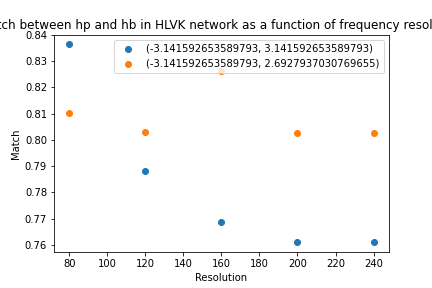

In [24]:
# save and store figures

from IPython.display import Image
Image(filename='/fs/lustre/cita/jewelcao/plots/freq_resolution.png') 

In [25]:
with open("/fs/lustre/cita/jewelcao/plots/freq_resolution_meta.pickle",'rb') as file: 
    result = pickle.load(file)
    print(result)

{'a': 'CE_fsr', 'c': 0.0001, 'strain_res': 45, 'psi_phi_res': 16, 'true_mode': 'hp', 'strain_mode': 'hb', 'network': 'HLVK'}


In [26]:
names_numpts = [80, 120, 160, 200, 240]

matches_numpts = {}
for i in range(2):
    matches = []
    for name in names_numpts: 
        with open(f"../results/frequency_resolution/results_{i}_numpts{name}.pickle",'rb') as file: 
            result = pickle.load(file)
            matches.append(result['match'])
    matches_numpts[f'{i}'] = matches

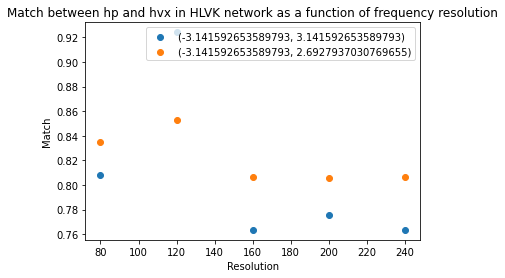

In [28]:
true_coords = [(-np.pi, np.pi), (-3.141592653589793, 2.6927937030769655), (np.pi, np.pi), (np.pi, 0)]

plt.title('Match between hp and hvx in HLVK network as a function of frequency resolution')
plt.xlabel('Resolution')
plt.ylabel('Match')
plt.scatter(names_numpts, matches_numpts['0'], label=f'{true_coords[0]}')
plt.scatter(names_numpts, matches_numpts['1'], label=f'{true_coords[1]}')
plt.legend()
plt.savefig('/fs/lustre/cita/jewelcao/plots/freq_resolution_hvx')
plt.show()

info_numpts = {'a':'CE_fsr', 'c':1e-4, 'strain_res':45, 'psi_phi_res':16, 
        'true_mode': 'hp', 'strain_mode':'hvx', 'network':'HLVK'}

with open('/fs/lustre/cita/jewelcao/plots/freq_resolution_hvx_meta.pickle', 'wb') as fp:
    pickle.dump(info_numpts, fp, protocol=pickle.HIGHEST_PROTOCOL)